# Mid-level benchmarks

The "mid-level" benchmarks are circuits that perform a simple operation, that could potentially be a building block of a real-life application.
We look at three examples here, and illustrate how we can visualize the results.

# 1) Private Information Retrieval (PIR)

One application of HE is to retrieve a data point from a database held elsewhere, without the database holder knowing which point is being requested. If Alice wants to query Bob's database, she simply encrypts an array full of zeros, except for a "1" in the position of the desired data point, and sends this ciphertext to Bob. He then performs homomorphic multiplication and addition, and sends the ciphertext back to Alice, who decrypts it to retrieve the data point she requested.

To demonstrate this on a very small scale, lets look at a "database" containing only two values: 123 and 456:

In [1]:
import os
import sys
if "SHEEP_HOME" in os.environ.keys():
  SHEEP_HOME = os.environ["SHEEP_HOME"]
  sys.path.append(SHEEP_HOME)
else:
  print("Please set SHEEP_HOME environment variable to point to location of SHEEP/frontend")

## tabulating and plotting benchmark results
import pandas as pd
import matplotlib.pyplot as plt
from pysheep.database import session, BenchmarkMeasurement, Timing

from pysheep.mid_level_benchmarks import generate_pir_circuit, \
    generate_variance_circuit, generate_bitonic_sort_circuit, generate_gaussian_inputs
from pysheep import benchmark_utils
from pysheep import common_utils
from pysheep import sheep_client

First lets setup the SHEEP client (assuming the SHEEP server is running).  We can choose the "HElib_Fp" context, and the input type to be 8-bit integers.

In [2]:
sheep_client.new_job() 
sheep_client.set_context("HElib_Fp")
sheep_client.set_input_type("int16_t")

{'content': '', 'status_code': 200}

Now let's generate the circuit file for this simple PIR case with two values in the "database":

In [3]:
circuit_file=generate_pir_circuit(2,[2])

Lets give this to the SHEEP server, and then see what inputs it expects?

In [4]:
sheep_client.set_circuit(circuit_file)
sheep_client.get_inputs()

{'content': ['d_0_0_0', 'd_0_1_0', 's_0_0', 's_0_1'], 'status_code': 200}

"d_a_b_c" are the "database" values, and "s_x_y" are the "selector" values.  We can set d_0_0_0 and d_0_1_0 to "123" and "456" respectively.  Then, to select d_0_0_0 (which will hopefully be the value "123") from the database, we should set s_0_0 to 1 and s_0_1 to zero.

In [5]:
sheep_client.set_inputs({"d_0_0_0": [123], "d_0_1_0": [456], "s_0_0": [1], "s_0_1": [0]})

{'content': '', 'status_code': 200}

In [6]:
sheep_client.run_job()
results = sheep_client.get_results()
results

{'content': {'cleartext check': {'is_correct': True},
  'outputs': {'e_0_0': ['123']},
  'timings': {'c_0_0_0': '1315.700000',
   'c_0_1_0': '1261.100000',
   'decryption': '558.000000',
   'e_0_0': '66.000000',
   'encryption': '3677.500000',
   'evaluation': '2853.100000'}},
 'status_code': 200}

So we successfully got the output value "123", i.e. the first entry in the "database".

## PIR with a more complex circuit

In [7]:
sheep_client.new_job()
sheep_client.set_input_type("int16_t")
sheep_client.set_context("HElib_Fp")

{'content': '', 'status_code': 200}

Assuming we will normally want to query a database containing N>2 items, one might think that we need to encrypt and send N "s"-values to identify the data point that we want.  However, we can be smarter than that by using a binary tree structure for the data, and having the "s"-values dictate how we navigate the tree to locate the desired data point. 

Lets generate a circuit file corresponding to a database containing 32 values, arranged in a tree with 5 layers and 2 choices per layer ($2^5 = 32$).

In [8]:
circuit_file=generate_pir_circuit(32,[2,2,2,2,2])
circuit_file

'/frontend/benchmark_inputs/mid_level/circuits/circuit-pir-32_2_2_2_2_2.sheep'

Let's now fill this database with values 0-to-31:

In [9]:
sheep_client.set_circuit(circuit_file)
inputlist=sheep_client.get_inputs()['content']
data = [(x, [i]) for (i, x) in enumerate(inputlist) if x.startswith('d_')]

To start with, we'll set all the "s" (selector) inputs to zero:

In [10]:
data += [(x, [0]) for (i, x) in enumerate(inputlist) if x.startswith('s_')]
data = dict(data)

Now we need to set certain selector variables to "1" to navigate down the tree.  Suppose we want to choose the last element of the database (should be value "31") - we need to go down the right-hand branches:

In [11]:
data['s_0_1'] = [1]
data['s_1_1'] = [1]
data['s_2_1'] = [1]
data['s_3_1'] = [1]
data['s_4_1'] = [1]

In [12]:
sheep_client.set_inputs(data)
sheep_client.set_timeout(120)
sheep_client.set_parameters({"Levels": 30})

{'content': '', 'status_code': 200}

In [13]:
sheep_client.run_job()

{'content': '', 'status_code': 200}

In [20]:
results = sheep_client.get_results()
results

{'content': {'cleartext check': {'is_correct': False},
  'outputs': {'e_4_0': ['19519']},
  'timings': {'c_0_0_0': '6116.600000',
   'c_0_0_1': '5213.100000',
   'c_0_0_10': '5349.300000',
   'c_0_0_11': '5282.600000',
   'c_0_0_12': '5222.100000',
   'c_0_0_13': '5344.800000',
   'c_0_0_14': '5368.300000',
   'c_0_0_15': '5172.800000',
   'c_0_0_2': '5266.400000',
   'c_0_0_3': '5279.900000',
   'c_0_0_4': '5247.000000',
   'c_0_0_5': '5283.700000',
   'c_0_0_6': '5203.200000',
   'c_0_0_7': '5274.500000',
   'c_0_0_8': '5240.300000',
   'c_0_0_9': '5279.000000',
   'c_0_1_0': '5178.100000',
   'c_0_1_1': '5272.900000',
   'c_0_1_10': '5283.500000',
   'c_0_1_11': '5217.900000',
   'c_0_1_12': '5257.300000',
   'c_0_1_13': '5255.600000',
   'c_0_1_14': '5271.800000',
   'c_0_1_15': '5375.600000',
   'c_0_1_2': '5200.000000',
   'c_0_1_3': '5214.600000',
   'c_0_1_4': '5247.400000',
   'c_0_1_5': '5214.300000',
   'c_0_1_6': '5275.800000',
   'c_0_1_7': '5209.800000',
   'c_0_1_8': '52

So we can see that we correctly selected the value '31'.

Now lets upload this result to the database, and repeat using SEAL_BFV.


In [15]:
benchmark_utils.upload_results("PIR_32_2")

True

In [16]:
sheep_client.new_job()
sheep_client.set_context("SEAL_BFV")
sheep_client.set_input_type("int16_t")
sheep_client.set_circuit(circuit_file)
sheep_client.set_inputs(data)
sheep_client.set_timeout(120)
sheep_client.run_job()

{'content': '', 'status_code': 200}

In [17]:
benchmark_utils.upload_results("PIR_32_2")

True

### Plotting the results

We now have the benchmark results in the "benchmarks" table of the SQLite database.  We can query this, and see how long HElib and SEAL_BFV spent on each operation while processing this circuit.

In [18]:
circuit = sheep_client.get_circuit()["content"]["circuit"]
rows = session.query(BenchmarkMeasurement).filter_by(circuit_name="PIR_32_2").all()
df_dict = {"Context": [], "Gate": [], "Time": []}
for row in rows:
    timingdict = benchmark_utils.timing_per_gate_type(row.timings, circuit)
    for k,v in timingdict.items():
        df_dict["Context"].append(row.context)
        df_dict["Gate"].append(k)
        df_dict["Time"].append(v)
df = pd.DataFrame(df_dict)
df

,Context,Gate,Time
0,HElib_Fp,MULTIPLY,246666.0
1,HElib_Fp,ALIAS,3043.2
2,HElib_Fp,ADD,6248.5
3,SEAL_BFV,MULTIPLY,331335.4
4,SEAL_BFV,ALIAS,1032.5
5,SEAL_BFV,ADD,2978.1


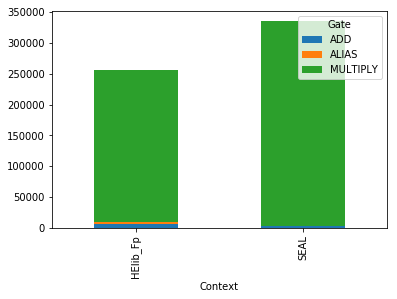

In [19]:
pivot_df = df.pivot(index='Context', columns='Gate', values='Time')
pivot_df.plot(kind='bar',stacked=True)

We can see that "MULTIPLY" is the most time-consuming operation, and SEAL_BFV is slightly slower than HElib.

# 2) Calculating mean and variance of a set of inputs

One may wish to calculate statistical properties of a set of encrypted inputs, such as mean, standard deviation etc.   Currently the contexts implemented in SHEEP do not have "Divide" operations, so calculating these exact values via only homomorphic operations on the ciphertext is not possible.  

However, the client will necessarily know "N", the number of inputs, so can perform division in the clear on the decrypted results of the homomorphic calculations.

We therefore only need homomorphic addition and multiplication.  Simply summing the inputs $x_i$ gives us $N\bar{x}$. 
Meanwhile $\Sigma_{i=0}^N(Nx_i - N\bar{x})^2$  is $N^3$ times the variance.



In [23]:
# reset the sheep server settings, - this time we'll use uint32_t and SEAL_BFV
sheep_client.new_job()
sheep_client.set_input_type("uint32_t")
sheep_client.set_context("SEAL_BFV")

{'content': '', 'status_code': 200}

Let's generate a circuit to calculate $(N \times mean)$ and ($N^3 \times variance)$ of a set of 10 inputs:

In [24]:
num_inputs = 10
circuit_file = generate_variance_circuit(num_inputs)
sheep_client.set_circuit(circuit_file)
print(sheep_client.get_circuit()["content"]["circuit"])

CONST_INPUTS N
INPUTS x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9
OUTPUTS Nxbar varianceN3
 x_0 x_1 ADD y_0
 y_0 x_2 ADD y_1
 y_1 x_3 ADD y_2
 y_2 x_4 ADD y_3
 y_3 x_5 ADD y_4
 y_4 x_6 ADD y_5
 y_5 x_7 ADD y_6
 y_6 x_8 ADD y_7
 y_7 x_9 ADD y_8
 y_8 ALIAS Nxbar
 x_0 N MULTBYCONST Nx_0
 Nxbar Nx_0 SUBTRACT v_0
 v_0 ALIAS vv_0
 v_0 vv_0 MULTIPLY s_0
 x_1 N MULTBYCONST Nx_1
 Nxbar Nx_1 SUBTRACT v_1
 v_1 ALIAS vv_1
 v_1 vv_1 MULTIPLY s_1
 x_2 N MULTBYCONST Nx_2
 Nxbar Nx_2 SUBTRACT v_2
 v_2 ALIAS vv_2
 v_2 vv_2 MULTIPLY s_2
 x_3 N MULTBYCONST Nx_3
 Nxbar Nx_3 SUBTRACT v_3
 v_3 ALIAS vv_3
 v_3 vv_3 MULTIPLY s_3
 x_4 N MULTBYCONST Nx_4
 Nxbar Nx_4 SUBTRACT v_4
 v_4 ALIAS vv_4
 v_4 vv_4 MULTIPLY s_4
 x_5 N MULTBYCONST Nx_5
 Nxbar Nx_5 SUBTRACT v_5
 v_5 ALIAS vv_5
 v_5 vv_5 MULTIPLY s_5
 x_6 N MULTBYCONST Nx_6
 Nxbar Nx_6 SUBTRACT v_6
 v_6 ALIAS vv_6
 v_6 vv_6 MULTIPLY s_6
 x_7 N MULTBYCONST Nx_7
 Nxbar Nx_7 SUBTRACT v_7
 v_7 ALIAS vv_7
 v_7 vv_7 MULTIPLY s_7
 x_8 N MULTBYCONST Nx_8
 Nxbar Nx_8 SUB

To generate the inputs, lets use a Gaussian with $\mu=50$ and $\sigma = 10$ (all input values rounded to integers):

In [25]:
input_vals = generate_gaussian_inputs(num_inputs,50,10)
input_vals

{'x_0': [41],
 'x_1': [62],
 'x_2': [73],
 'x_3': [53],
 'x_4': [52],
 'x_5': [54],
 'x_6': [45],
 'x_7': [41],
 'x_8': [16],
 'x_9': [52]}

In [26]:
sheep_client.set_inputs(input_vals)
sheep_client.set_const_inputs({"N": 10})

{'content': '', 'status_code': 200}

In [27]:
sheep_client.run_job()
results = sheep_client.get_results()['content']

In [28]:
results["outputs"]

{'Nxbar': ['489'], 'varianceN3': ['39846']}

In the clear, we can then divide these by $N$ and $N^3$ respectively:

In [29]:
print(float(results["outputs"]["Nxbar"][0])/num_inputs , float(results["outputs"]["varianceN3"][0])/pow(num_inputs,3))

48.9 39.846


# 3) Bitonic sort

Sorting a list of inputs is another non-trivial operation that can be performed using a combination of straightforward homomorphic operations - namely "Select" and "Compare".


In [30]:
sheep_client.new_job()
sheep_client.set_input_type("int8_t")
sheep_client.set_context("HElib_F2")
circuit_file = os.path.join(SHEEP_HOME,"benchmark_inputs","mid_level","circuits","circuit-bitonic-sort-4.sheep")
sheep_client.set_circuit(circuit_file)

{'content': '', 'status_code': 200}

What inputs does this circuit expect?

In [31]:
sheep_client.get_inputs()

{'content': ['i0', 'i1', 'i2', 'i3'], 'status_code': 200}

In [32]:
sheep_client.set_inputs({"i0":[4],"i1":[8],"i2":[1],"i3": [3]})

{'content': '', 'status_code': 200}

In [33]:
sheep_client.set_timeout(120)
sheep_client.run_job()
results_helib = sheep_client.get_results()['content']

In [34]:
results_helib["outputs"]

{'w31': ['1'], 'w32': ['3'], 'w36': ['4'], 'w37': ['8']}

So we can see that we now have the outputs in the correct order.

Now lets upload the results to the database and then do the same test with TFHE.

In [35]:
benchmark_utils.upload_results("bitonic_sort_4")

True

In [36]:
sheep_client.new_job()
sheep_client.set_timeout(120)
sheep_client.set_input_type("int8_t")
sheep_client.set_context("TFHE")
sheep_client.set_circuit(circuit_file)
sheep_client.set_inputs({"i0":[4],"i1":[8],"i2":[1],"i3": [3]})
sheep_client.run_job()


{'content': '', 'status_code': 200}

In [37]:
results_tfhe = sheep_client.get_results()

In [38]:
results_tfhe

{'content': {'cleartext check': {'is_correct': True},
  'outputs': {'w31': ['1'], 'w32': ['3'], 'w36': ['4'], 'w37': ['8']},
  'timings': {'decryption': '35.100000',
   'encryption': '725.100000',
   'evaluation': '9422061.200000',
   'w10': '8.700000',
   'w11': '8.800000',
   'w12': '8.800000',
   'w13': '842462.600000',
   'w14': '344226.800000',
   'w15': '354294.200000',
   'w16': '10.500000',
   'w17': '8.700000',
   'w22': '819884.500000',
   'w23': '344459.100000',
   'w24': '356507.100000',
   'w25': '837959.100000',
   'w26': '357210.200000',
   'w27': '350711.300000',
   'w28': '880318.000000',
   'w29': '395189.600000',
   'w30': '393269.900000',
   'w31': '10.200000',
   'w32': '9.100000',
   'w33': '884782.300000',
   'w34': '353324.700000',
   'w35': '377518.800000',
   'w36': '10.100000',
   'w37': '8.600000',
   'w4': '14.700000',
   'w5': '8.700000',
   'w6': '834593.500000',
   'w7': '350644.300000',
   'w8': '343545.500000',
   'w9': '10.700000'}},
 'status_code': 2

In [39]:
benchmark_utils.upload_results("bitonic_sort_4")

True

### Plotting the results

Lets compare how TFHE and HElib_F2 did on the 4-element bitonic sort circuit.

In [40]:
circuit = sheep_client.get_circuit()["content"]["circuit"]
rows = session.query(BenchmarkMeasurement).filter_by(circuit_name="bitonic_sort_4").all()
df_dict = {"Context": [], "Gate": [], "Time": []}
for row in rows:
    timingdict = benchmark_utils.timing_per_gate_type(row.timings, circuit)
    for k,v in timingdict.items():
        df_dict["Context"].append(row.context)
        df_dict["Gate"].append(k)
        df_dict["Time"].append(v)
df = pd.DataFrame(df_dict)
df

,Context,Gate,Time
0,HElib_F2,SELECT,841047.6
1,HElib_F2,COMPARE,44516670.6
2,HElib_F2,ALIAS,2556.9
3,TFHE,SELECT,4320901.5
4,TFHE,COMPARE,5100000.0
5,TFHE,ALIAS,117.6


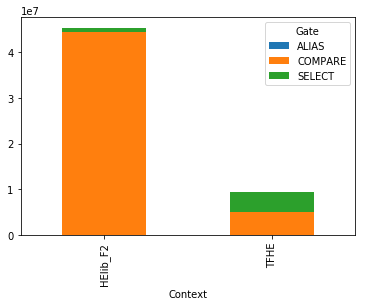

In [41]:
pivot_df = df.pivot(index='Context', columns='Gate', values='Time')
pivot_df.plot(kind='bar',stacked=True)

So we can see that for this bitonic sort circuit, COMPARE is the most time-consuming operation, and TFHE is substantially faster than HElib_F2.